# Правила

Цель игры состоит в том, чтобы набрать наибольшее общее количество очков. Очки можно получить за: 
- Прохождение маршрута между двумя соседними городами на карте; 
- Успешное завершение непрерывного пути маршрутов между двумя городами, указанными в ваших билетах назначения; 
- Завершение самого длинного непрерывного пути маршрутов, чтобы выиграть карту European Express Bonus; 
- И за каждый вокзал, оставленный в резерве на конец игры. Очки вычитаются из общего количества очков игроков за каждый из их билетов назначения, которые не были успешно завершены к концу игры.

## What to consider: 
- Fing centers
- find trains positions and colors
- what if we did'nt find some centers?

In [1]:
from typing import Union

from collections import defaultdict
from itertools import combinations
import json

import numpy as np
import cv2
from skimage.transform import rescale
from skimage.measure import label, find_contours
from skimage.filters import gaussian
from scipy.spatial.distance import cdist
import scipy.stats as st

import matplotlib.pyplot as plt

In [2]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

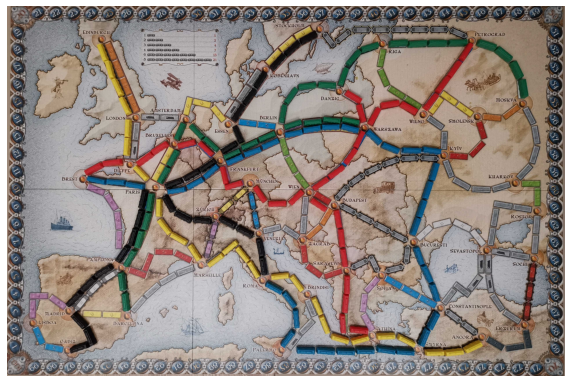

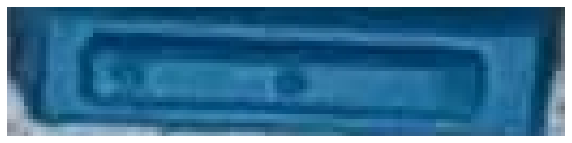

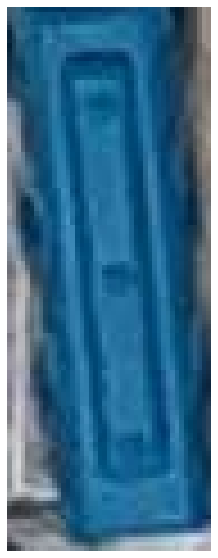

In [3]:
img = cv2.imread('train/all.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plot_img(img_rgb)
blue_template = img_rgb[2365:2395, 1995:2125]
blue_template2 = img_rgb[2100:2220, 1970:2015]
plot_img(blue_template)
plot_img(blue_template2)




In [4]:
print(img_rgb.shape)

(2546, 3846, 3)


In [5]:
from skimage.feature import match_template

match_blue = match_template(img_rgb, blue_template)
match_blue2 = match_template(img_rgb, blue_template2)


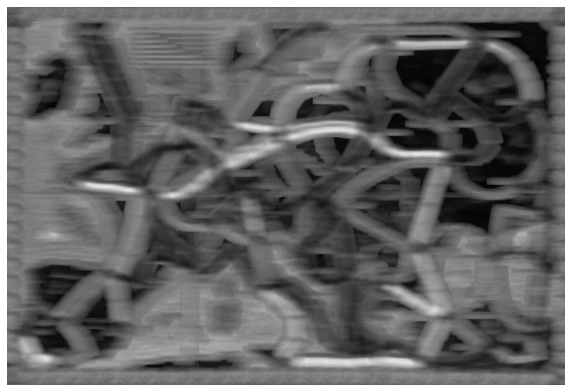

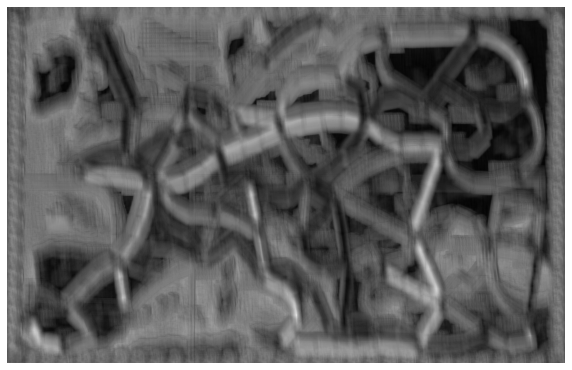

In [6]:
plot_img(match_blue)
plot_img(match_blue2)

In [7]:
print(match_blue.shape)

(2517, 3717, 1)


-0.8495742485654945 0.9999999999999994
bool


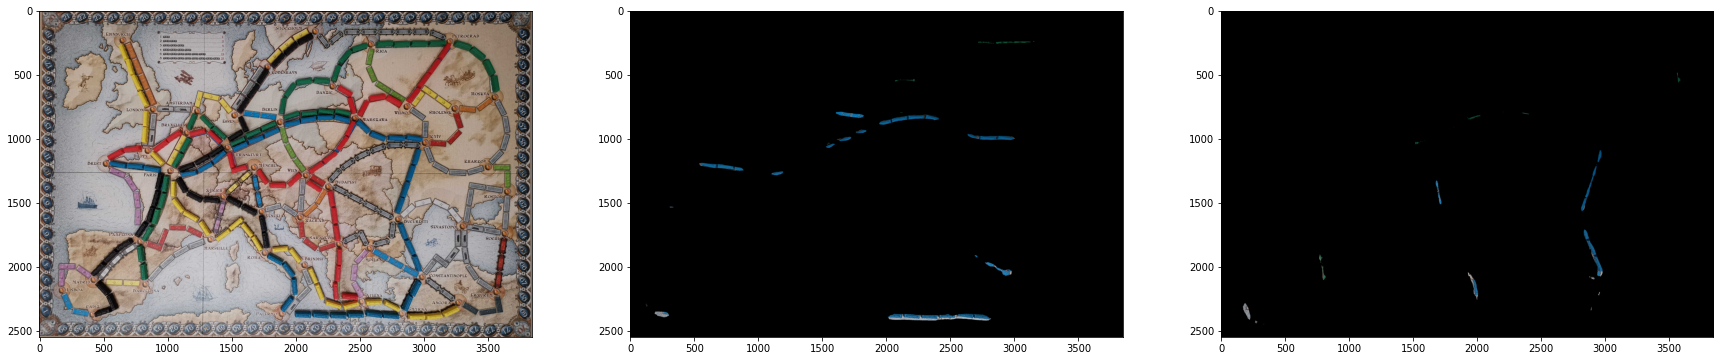

In [8]:
print(match_blue.min(), match_blue.max())

print( (match_blue>0.3).dtype)
match_blue_resize = cv2.resize(np.repeat((match_blue > 0.5).astype(np.float64), 3, axis=2), (3846, 2546))
img_rgb_masked = img_rgb * match_blue_resize.astype(np.int32)
match_blue_resize2 = cv2.resize(np.repeat((match_blue2 > 0.4).astype(np.float64), 3, axis=2), (3846, 2546))
img_rgb_masked2 = img_rgb * match_blue_resize2.astype(np.int32)

fig, ax = plt.subplots(1,3, figsize=(30,10))

ax[0].imshow(img_rgb)
ax[1].imshow(img_rgb_masked)
ax[2].imshow(img_rgb_masked2);


## It was a bad idea to use skimage.feature.match_template for train searchin. So let's use it for cities

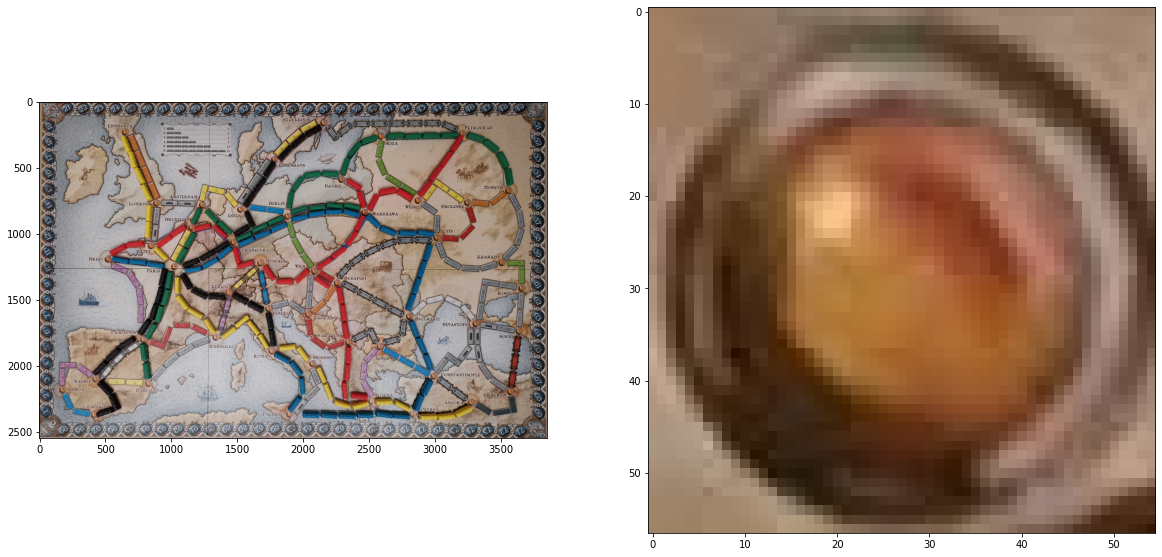

In [9]:
city_templ = img_rgb[199:256, 625:680]

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_rgb)
ax[1].imshow(city_templ);

In [10]:
match_cities = match_template(img_rgb, city_templ)

In [11]:
print(match_cities.shape)
print(match_cities.min(), match_cities.max())

(2490, 3792, 1)
-0.5870721908987138 1.0000000000000007


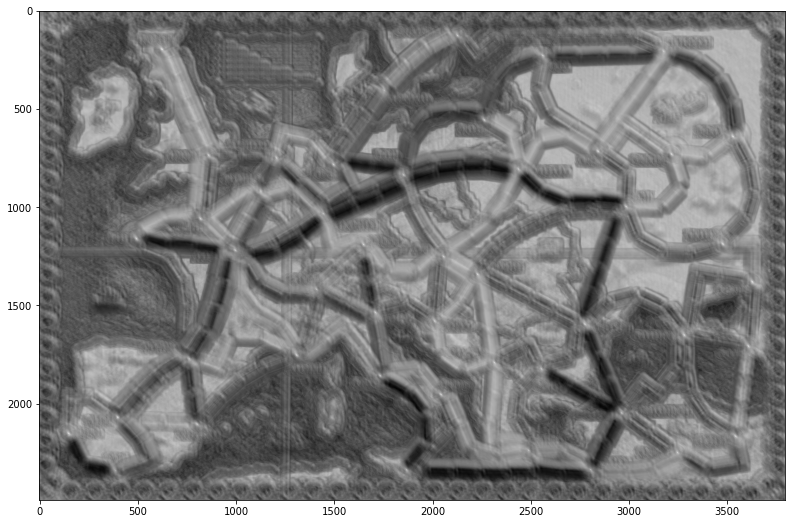

In [12]:
fig, ax = plt.subplots(figsize=(16,9))

ax.imshow(match_cities, cmap='gray');

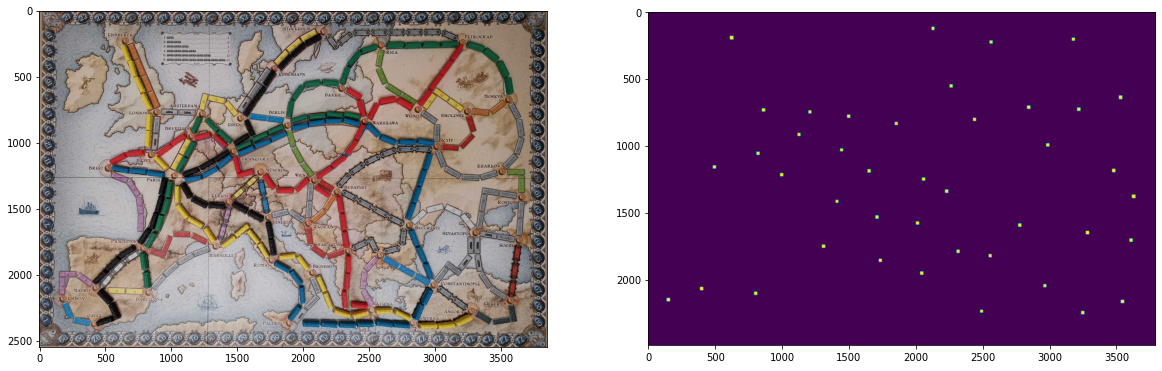

In [13]:
fig,ax = plt.subplots( 1,2, figsize=(20,10))

ax[0].imshow(img_rgb)
ax[1].imshow(cv2.dilate( (match_cities > 0.7).astype(np.float64), np.ones((3,3)), iterations=10));

In [14]:
# Retrive ROI of city from centers (from .json)

TRAIN_CASES = {i: fname for i, fname in enumerate(('all', 'black_blue_green', 'black_red_yellow',
                                                   'red_green_blue_inaccurate', 'red_green_blue'))}
all_centers = load_json(f'train/{TRAIN_CASES[0]}_centers.json')
all_centers = np.array(all_centers)

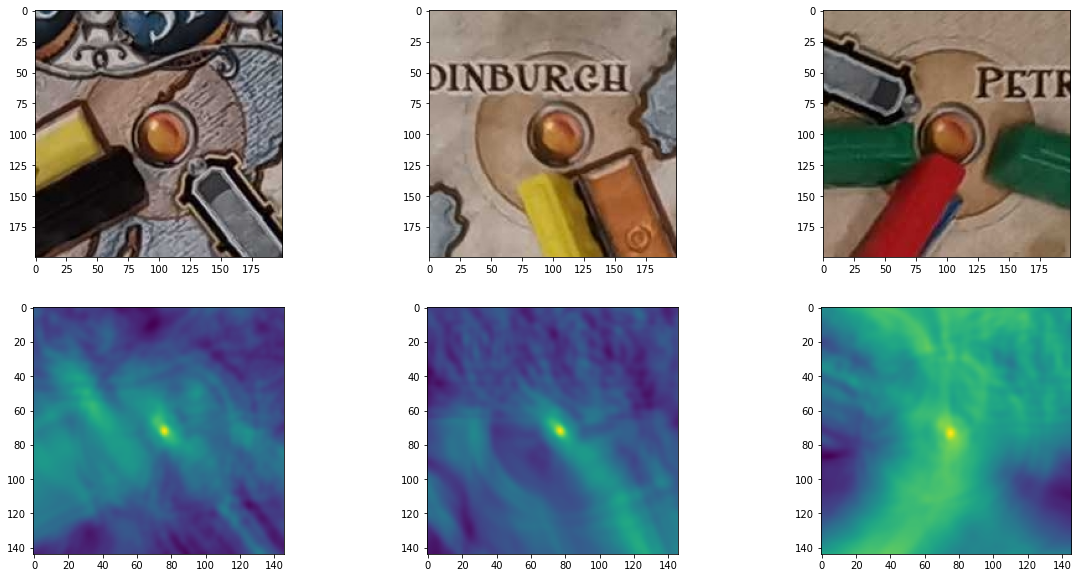

In [15]:
fig,ax = plt.subplots( 2,3, figsize=(20,10))

for i in range(3):
    roi = img_rgb[all_centers[i,0]-100:all_centers[i,0]+100, all_centers[i,1]-100:all_centers[i,1]+100]
    match = match_template(roi, city_templ)
    ax[0][i].imshow(roi)
    ax[1][i].imshow(match)


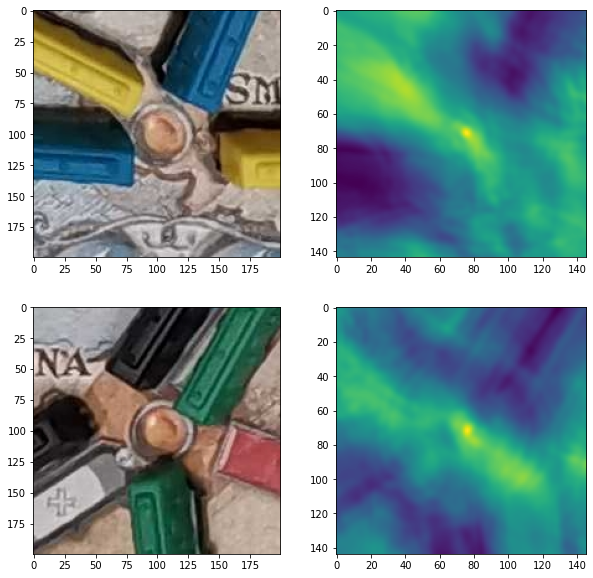

In [16]:
# find har detectable cities
smyrna = np.array([2363, 2827])
pamplona = np.array([1800, 787])

fig,ax = plt.subplots( 2,2, figsize=(10,10))

roi = img_rgb[smyrna[0]-100:smyrna[0]+100, smyrna[1]-100:smyrna[1]+100]
match = match_template(roi, city_templ)
ax[0,0].imshow(roi)
ax[0,1].imshow(match)

roi = img_rgb[pamplona[0]-100:pamplona[0]+100, pamplona[1]-100:pamplona[1]+100]
match = match_template(roi, city_templ)
ax[1,0].imshow(roi)
ax[1,1].imshow(match);

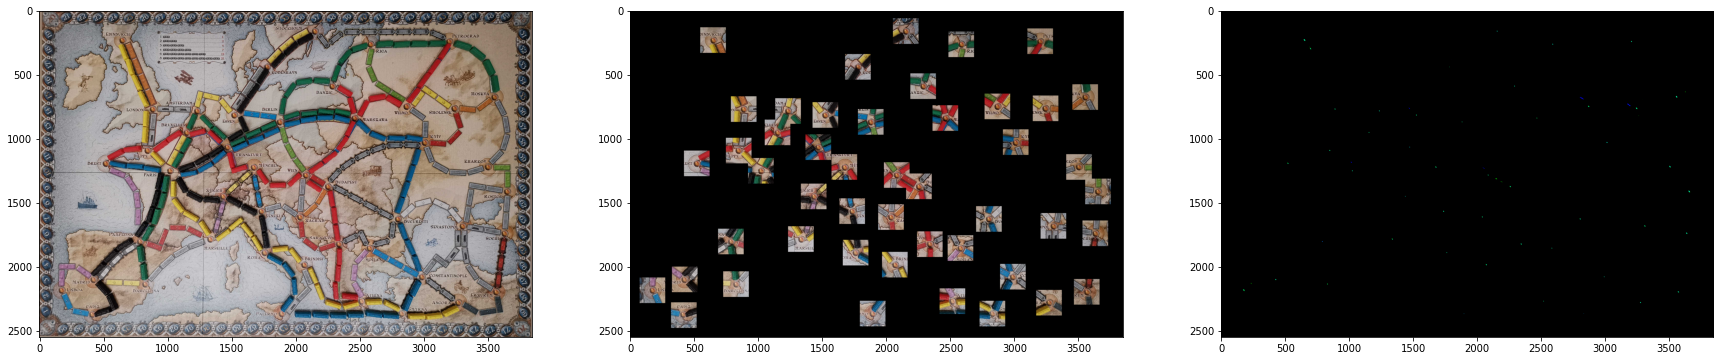

In [17]:
approx_centers = np.array([[157, 2151], [227, 648], [236, 3200], [260, 2584], [436, 1778], [587, 2287], [672, 3551], [745, 2866], [760, 3242], [766, 887], [781, 1233], [812, 1524], [836, 2460], [866, 1878], [948, 1151], [1024, 3009], [1063, 1469], [1090, 848], [1190, 521], [1218, 3503], [1218, 1672], [1248, 1021], [1281, 2081], [1369, 2254], [1409, 3651], [1448, 1433], [1563, 1733], [1609, 2036], [1624, 2800], [1678, 3303], [1736, 3630], [1781, 1333], [1800, 787], [1821, 2339], [1851, 2578], [1887, 1760], [1981, 2066], [2075, 2987], [2096, 427], [2133, 827], [2181, 175], [2193, 3563], [2266, 2515], [2278, 3269], [2363, 2827], [2363, 1893], [2375, 420]])
# x, y
# x, y
approx_mask = np.zeros(img_rgb.shape)
match_mask = np.zeros(img_rgb.shape)
for pt in approx_centers:
    roi = img_rgb[pt[0]-100:pt[0]+100, pt[1]-100:pt[1]+100]
    match = match_template(roi, city_templ, pad_input=True)
    # match_mask[pt[0]-100:pt[0]+100, pt[1]-100:pt[1]+100] = cv2.erode((match > 0.6).astype(np.float64), kernel=np.ones((3,3)), iterations=10)
    match_mask[pt[0]-100:pt[0]+100, pt[1]-100:pt[1]+100] = match > 0.6
    approx_mask[pt[0]-100:pt[0]+100, pt[1]-100:pt[1]+100] = 1


fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].imshow(img_rgb)
ax[1].imshow(img_rgb * approx_mask.astype(np.int32));
ax[2].imshow(match_mask);


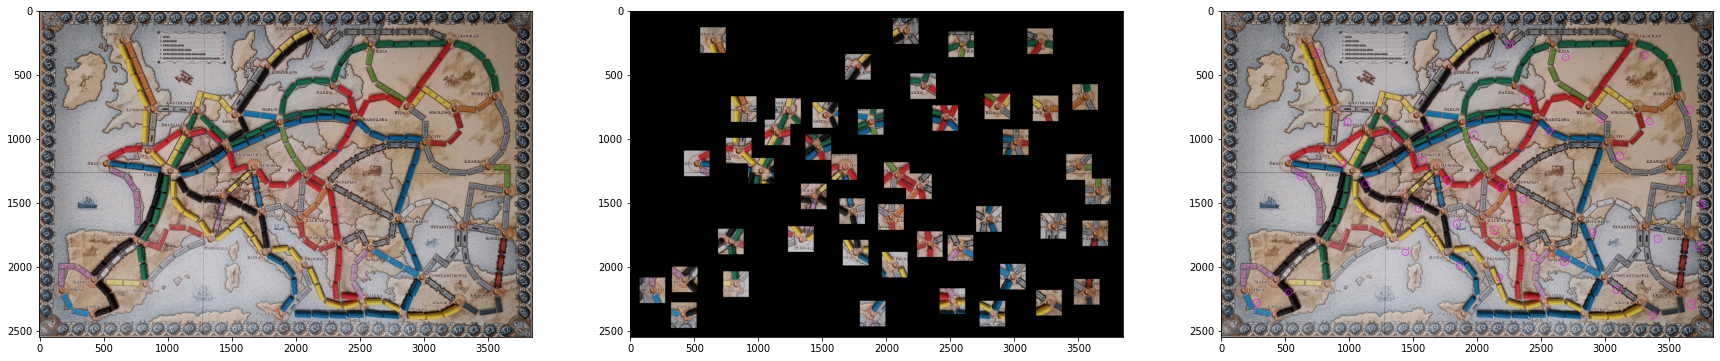

In [26]:
approx_centers = np.array([[157, 2151], [227, 648], [236, 3200], [260, 2584], [436, 1778], [587, 2287], [672, 3551], [745, 2866], [760, 3242], [766, 887], [781, 1233], [812, 1524], [836, 2460], [866, 1878], [948, 1151], [1024, 3009], [1063, 1469], [1090, 848], [1190, 521], [1218, 3503], [1218, 1672], [1248, 1021], [1281, 2081], [1369, 2254], [1409, 3651], [1448, 1433], [1563, 1733], [1609, 2036], [1624, 2800], [1678, 3303], [1736, 3630], [1781, 1333], [1800, 787], [1821, 2339], [1851, 2578], [1887, 1760], [1981, 2066], [2075, 2987], [2096, 427], [2133, 827], [2181, 175], [2193, 3563], [2266, 2515], [2278, 3269], [2363, 2827], [2363, 1893], [2375, 420]])
# x, y
# x, y
approx_mask = np.zeros(img_rgb.shape)
match_img = img_rgb.copy()

min_r = 25
max_r = 35

gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
for pt in approx_centers:
    roi = gray[pt[0]-100:pt[0]+100, pt[1]-100:pt[1]+100]
    circles = cv2.HoughCircles(roi, cv2.HOUGH_GRADIENT, 1, 100,
                               param1=100, param2=30,
                               minRadius=min_r, maxRadius=max_r)
    approx_mask[pt[0]-100:pt[0]+100, pt[1]-100:pt[1]+100] = 1
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circ in circles[0, :]:
            center = (circ[0]+pt[1], circ[1]+pt[0])
            # circle center
            match_img = cv2.circle(match_img, center, 1, (0, 100, 100), 3)
            # circle outline
            radius = circ[2]
            match_img = cv2.circle(match_img, center, radius, (255, 0, 255), 3)

fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].imshow(img_rgb)
ax[1].imshow(img_rgb * approx_mask.astype(np.int32));
ax[2].imshow(match_img);


None
None


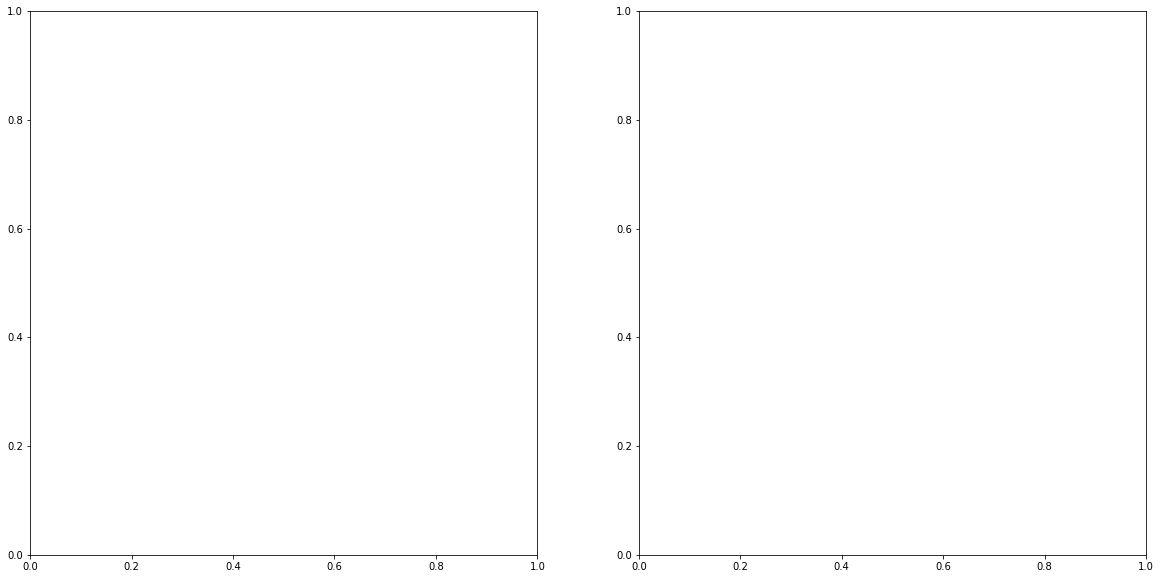

In [56]:
fig,ax = plt.subplots( 1,2, figsize=(20,10))

roi = img_rgb[smyrna[0]-100:smyrna[0]+100, smyrna[1]-100:smyrna[1]+100]
roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
circles = cv2.HoughCircles(roi_gray, cv2.HOUGH_GRADIENT, 1, 100,
                               param1=200, param2=100,
                               minRadius=min_r, maxRadius=max_r)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])
        # circle center
        roi_det = cv2.circle(roi, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = circ[2]
        roi_det = cv2.circle(roi_det, center, radius, (255, 0, 255), 3)
    ax[0].imshow(roi_det)

print(circles)

roi = img_rgb[pamplona[0]-100:pamplona[0]+100, pamplona[1]-100:pamplona[1]+100]
roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
roi_det = 
circles = cv2.HoughCircles(roi_gray, cv2.HOUGH_GRADIENT, 1, 100,
                               param1=200, param2=100,
                               minRadius=1, maxRadius=100)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])
        # circle center
        roi_det = cv2.circle(roi, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = circ[2]
        roi_det = cv2.circle(roi_det, center, radius, (255, 0, 255), 3)
    ax[1].imshow(roi_det);

print(circles)



In [40]:
print(circles)

None


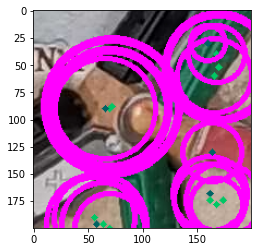

In [57]:
plt.imshow(roi)

In [51]:
from ipywidgets import IntSlider, interact

sld = IntSlider(value=100, min=0, max=255, step=1, continuous_update=False)

roi = img_rgb[pamplona[0]-100:pamplona[0]+100, pamplona[1]-100:pamplona[1]+100]
roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

def vary_p1(p1=100):
    
    circles = cv2.HoughCircles(roi_gray, cv2.HOUGH_GRADIENT, 1, 100,
                               param1=p1, param2=100,
                               minRadius=1, maxRadius=100)
    print(circles)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        print(circles)
        for circ in circles[0, :]:
            center = (circ[0], circ[1])
            # circle center
            roi_det = cv2.circle(roi, center, 1, (0, 100, 100), 3)
            # circle outline
            radius = circ[2]
            roi_det = cv2.circle(roi_det, center, radius, (255, 0, 255), 3)

            fig,ax = plt.subplots()
            ax.imshow(roi_det)
    else:
        fig,ax = plt.subplots()
        ax.imshow(roi)
    plt.show()

In [52]:
interact(vary_p1, p1=100);

interactive(children=(IntSlider(value=100, description='p1', max=300, min=-100), Output()), _dom_classes=('wid…

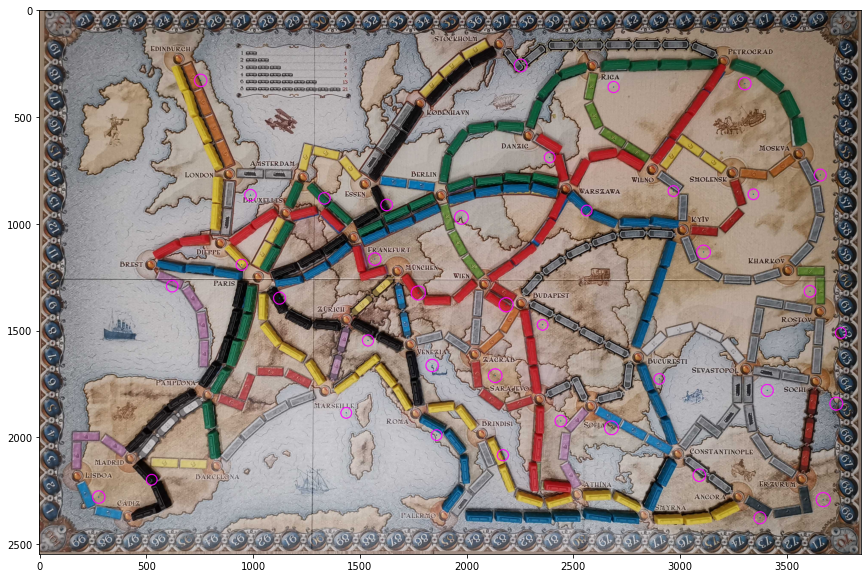

In [27]:
fig,ax = plt.subplots(figsize=(16,10))
ax.imshow(match_img);


## Train features matching

In [ ]:
# maybe before that find suspeios regions
# - match features
# - find homography
# - define the size of template train on image and make src = (np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2))
# - transform this src to dst with  dst = cv.perspectiveTransform(pts,M) 